## DATA AND VISU DATA

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the npz file
npz_file_path = "/Users/m19pham/Documents/Research/Projects/LiDAR2mesh/data/CNRS/283/SW_B_1_stageii.npz"
npz_smplx = "/Users/m19pham/Documents/Research/Projects/LiDAR2mesh/P4D/smplx/SMPLX_MALE.npz"
npz_file = np.load(npz_file_path)#, allow_pickle=True)
npz_file_smplx = np.load(npz_smplx, allow_pickle=True)  

# Extract the data
print("Extracting data...")
data = {}
for key in npz_file.keys():
    print(f"Key: {key}")
    try : 
        if npz_file[key].shape == ():
            print(f"Content: {npz_file[key]}")
        else:
            print(f"Shape: {npz_file[key].shape}")
    except:
         
        continue
    data[key] = npz_file[key]
    print(data[key].shape)
print("Data extracted.")

Extracting data...
Key: gender
Content: male
()
Key: surface_model_type
Content: smplx
()
Key: mocap_frame_rate
Content: 120.0
()
Key: mocap_time_length
Content: 5.483333333333333
()
Key: markers_latent
Shape: (50, 3)
(50, 3)
Key: latent_labels
Shape: (50,)
(50,)
Key: markers_latent_vids
Key: trans
Shape: (658, 3)
(658, 3)
Key: poses
Shape: (658, 165)
(658, 165)
Key: betas
Shape: (16,)
(16,)
Key: num_betas
Content: 16
()
Key: root_orient
Shape: (658, 3)
(658, 3)
Key: pose_body
Shape: (658, 63)
(658, 63)
Key: pose_hand
Shape: (658, 90)
(658, 90)
Key: pose_jaw
Shape: (658, 3)
(658, 3)
Key: pose_eye
Shape: (658, 6)
(658, 6)
Key: markers
Shape: (658, 57, 3)
(658, 57, 3)
Key: labels
Shape: (57,)
(57,)
Key: markers_obs
Shape: (658, 50, 3)
(658, 50, 3)
Key: labels_obs
Shape: (658, 50)
(658, 50)
Key: markers_sim
Shape: (658, 50, 3)
(658, 50, 3)
Key: marker_meta
Key: num_markers
Content: 57
()
Data extracted.


In [3]:
def matrix_to_rotation_6d(matrix):
    
    batch_dim = matrix.size()[:-2]
    return matrix[..., :2, :].clone().reshape(batch_dim + (6,))

In [6]:
import torch

from body_model import BodyModel
from utils import rodrigues_2_rot_mat#, rotation6d_2_rot_mat
from lbs import lbs, batch_rodrigues

from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex
import os

# Define the project root directory
# find the path to the project root directory
#PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

#PROJECT_ROOT = os.path.join(PROJECT_ROOT,'P4D')

# Define the path to SMPLX_MALE.npz using an absolute path
SMPLX_MODEL_MALE_PATH = "/Users/m19pham/Documents/Research/Projects/LiDAR2mesh/P4D/smplx/SMPLX_MALE.npz"



class SMPLX(BodyModel):
    def __init__(self, num_betas=16, **kwargs):
        super().__init__(bm_fname=SMPLX_MODEL_MALE_PATH, num_betas=num_betas, num_expressions=0, **kwargs)

    def forward(self, pose_body, betas, use_rodrigues=True):
        
        device = pose_body.device
        for name in ['init_pose_hand', 'init_pose_jaw','init_pose_eye', 'init_v_template', 'init_expression', 
                    'shapedirs', 'exprdirs', 'posedirs', 'J_regressor', 'kintree_table', 'weights', 'f']:
            _tensor = getattr(self, name)
            setattr(self, name, _tensor.to(device))

        batch_size = pose_body.shape[0]
        
        #trans = pose_body[:, :3] # No translation
        pose_hand = self.init_pose_hand.expand(batch_size, -1)
        pose_jaw = self.init_pose_jaw.expand(batch_size, -1)
        pose_eye = self.init_pose_eye.expand(batch_size, -1)
        v_template = self.init_v_template.expand(batch_size, -1, -1)
        expression = self.init_expression.expand(batch_size, -1)

        init_pose = torch.cat([pose_jaw, pose_eye, pose_hand], dim=-1) # [B, 99] full of zeros
        if not use_rodrigues:
            init_pose = rodrigues_2_rot_mat(init_pose) # [B, 99] -> [B, 33, 3, 3]
        #full_pose = torch.cat([pose_body[:, 3:], init_pose], dim=-1)
        
        full_pose = torch.cat([pose_body, init_pose], dim=-1) # No translation, concat of Pose body [B, 66] and init_pose [B, 99] = [B, 165]
        
        
        shape_components = torch.cat([betas, expression], dim=-1)
        shapedirs = torch.cat([self.shapedirs, self.exprdirs], dim=-1)
        

        verts, joints = lbs(betas=shape_components, pose=full_pose, v_template=v_template,
                        shapedirs=shapedirs, posedirs=self.posedirs, J_regressor=self.J_regressor,
                        parents=self.kintree_table[0].long(), lbs_weights=self.weights, pose2rot=use_rodrigues)
        
        faces = self.f.expand(batch_size, -1, -1)
        textures = torch.ones_like(verts)
        
        meshes = Meshes(
            verts=verts,
            faces=faces,
            textures=TexturesVertex(verts_features=textures)
        )

        # joints = joints + trans.unsqueeze(dim=1)
        # verts = verts + trans.unsqueeze(dim=1)
        
        return dict(meshes=meshes, verts=verts, joints=joints)

In [7]:
%load_ext autoreload
%autoreload 2

import torch
from matplotlib.animation import FuncAnimation
from utils import rodrigues_2_rot_mat#, rotation6d_2_rot_mat
from loss import GeodesicLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

smplx = SMPLX().to(device)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
pose_body = torch.tensor(data['pose_body'][:20, :], dtype=torch.float32).to(device) # 21 joints (63 vec)
root_orient = torch.tensor(data['root_orient'][:20, :], dtype=torch.float32).to(device) # 1 joints (3 vec)
#_input = torch.cat([root_orient, pose_body], dim=-1)



beta = torch.tensor(data['betas'], dtype=torch.float32).unsqueeze(0).repeat(4, 1).to(device)
_input = torch.zeros((4, 66)).to(device) # This is the axis angle representation of the pose
_input_rot_mat = rodrigues_2_rot_mat(_input)
_input_6d = matrix_to_rotation_6d(_input_rot_mat.view(4, -1, 3, 3)) 
_input_6d_rot_mat = rotation6d_2_rot_mat(_input_6d)

print("Input shape: ", _input.shape)
print("Input rot mat shape: ", _input_rot_mat.shape)
print("Input 6d shape: ", _input_6d.shape)
print("Input 6d rot mat shape: ", _input_6d_rot_mat.shape)
print("Beta shape: ", beta.shape)

target = smplx(pose_body=_input, betas=beta, use_rodrigues=True)
target_rot_mat = smplx(pose_body=_input_rot_mat, betas=beta, use_rodrigues=False)
target_6d_rot_mat = smplx(pose_body=_input_6d_rot_mat, betas=beta, use_rodrigues=False)

geo = GeodesicLoss()
loss = geo(_input_6d_rot_mat.view(4, -1, 3, 3), _input_rot_mat.view(4, -1, 3, 3))

print("Loss: ", loss)

meshes = target['meshes']
verts = target["verts"]
joints = target["joints"]

meshes_rot = target_rot_mat['meshes']
verts_rot = target_rot_mat["verts"]
joints_rot = target_rot_mat["joints"]

meshes_6d_rot = target_6d_rot_mat['meshes']
verts_6d_rot = target_6d_rot_mat["verts"]
joints_6d_rot = target_6d_rot_mat["joints"]


print("Vertices shape: ", verts.shape)
print("Joints shape: ", joints.shape)


verts = meshes.verts_padded()
faces = meshes.faces_padded()[0]

verts_rot = meshes_rot.verts_padded()
faces_rot = meshes_rot.faces_padded()[0]

verts_6d_rot = meshes_6d_rot.verts_padded()
faces_6d_rot = meshes_6d_rot.faces_padded()[0]



fig = plt.figure()
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ax1.plot_trisurf(verts[0, :, 0].cpu().numpy(), verts[0, :, 1].cpu().numpy(), verts[0, :, 2].cpu().numpy(), triangles=faces.cpu().numpy(), cmap='viridis', edgecolor='none')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)
ax1.view_init(elev=0, azim=150)

ax2.plot_trisurf(verts_rot[0, :, 0].cpu().numpy(), verts_rot[0, :, 1].cpu().numpy(), verts_rot[0, :, 2].cpu().numpy(), triangles=faces_rot.cpu().numpy(), cmap='viridis', edgecolor='none')
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_zlim(-1, 1)
ax2.view_init(elev=0, azim=150)

ax3.plot_trisurf(verts_6d_rot[0, :, 0].cpu().numpy(), verts_6d_rot[0, :, 1].cpu().numpy(), verts_6d_rot[0, :, 2].cpu().numpy(), triangles=faces_6d_rot.cpu().numpy(), cmap='viridis', edgecolor='none')
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_xlim(-1, 1)
ax3.set_ylim(-1, 1)
ax3.set_zlim(-1, 1)
ax3.view_init(elev=0, azim=150)

plt.show()

NameError: name 'rotation6d_2_rot_mat' is not defined

In [14]:
import trimesh

# Convert PyTorch tensors to NumPy arrays if necessary
verts_np = verts[0].cpu().numpy()
faces_np = faces.cpu().numpy()

# Create a Trimesh object
mesh = trimesh.Trimesh(vertices=verts_np, faces=faces_np)

# Create a scene and add the mesh
scene = trimesh.Scene()
scene.add_geometry(mesh)

scene.show()

ModuleNotFoundError: No module named 'trimesh'

In [ ]:
from lidar import LiDAR
import matplotlib.pyplot as plt
from dataset import load_and_split_all_datasets


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smpl = SMPLX().to(device)
lidar = LiDAR(
    elev=0.0,
    dist=6.0,
    image_size=(256, 192),
    min_depth=0.0,
    max_depth=1.0,
    device=device,
    return_normals=False,
    subsample=1024
)

list_data_names = ["../data/CNRS/283/SW_B_1_stageii.npz"] 
batch_size = 5
train_size, val_size, test_size = 0.7, 0.15, 0.15
step = 1
augment = 1

train_dataset, val_dataset, test_dataset = load_and_split_all_datasets(
    list_data_names, device, smpl, lidar, batch_size, train_size, val_size, test_size, step, augment
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Processing ../data/CNRS/283/SW_B_1_stageii.npz
Train dataset size: 91
Validation dataset size: 19
Test dataset size: 21


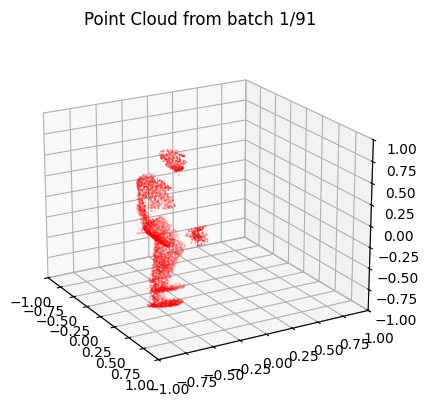

In [ ]:
batch_number = 0
poses, betas, verts, joints, pcs, azimuths, _ = val_dataset[batch_number]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc = pcs[:, :, :3].view(-1, 3).cpu().numpy()
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c='r', s=0.03)
ax.set_title(f"Point Cloud from batch {batch_number+1}/{len(train_dataset)}")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.view_init(elev=20, azim=-30)
plt.show()

In [ ]:
import gc

def optimize_memory():
    # Clear PyTorch CUDA cache
    torch.cuda.empty_cache()
    
    # Garbage collect Python objects
    gc.collect()

optimize_memory()

## TRAINER

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import os
import json
import glob

def visualize_meshes(real_verts, recon_verts, title, ax):
    ax.clear()
    ax.scatter(real_verts[:, 0], real_verts[:, 1], real_verts[:, 2], c='r', marker='o', s=0.01, label='Real')
    ax.scatter(recon_verts[:, 0], recon_verts[:, 1], recon_verts[:, 2], c='b', marker='o', s=0.01, label='Predicted')
    
    all_verts = torch.cat([real_verts, recon_verts], dim=0)
    min_vals = torch.min(all_verts, dim=0)[0] - 0.2
    max_vals = torch.max(all_verts, dim=0)[0] + 0.2
    
    ax.set_xlim(min_vals[0], max_vals[0])
    ax.set_ylim(min_vals[1], max_vals[1])
    ax.set_zlim(min_vals[2], max_vals[2])
    ax.view_init(elev=20, azim=45)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

def visualize_loss(loss_components, title, ax):
    ax.clear()
    for key, value in loss_components.items():
        ax.plot(value, label=key)
    ax.set_title(title)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

def train_one_epoch(model, optimizer, criterion, train_loader, epoch, all_loss, print_freq=20, visu=True, fig=None, axes=None):
    model.train()
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        poses, betas, verts, joints, pcs, azimuths, _ = batch
        poses = poses.squeeze(0)
        betas = betas.squeeze(0)

        pred_poses = model(pcs)
        loss, loss_components, pred_verts = criterion(pred_poses, poses, betas)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), 1)
        optimizer.step()
        
        total_loss += loss.item()

        with torch.no_grad():
            for key, value in loss_components.items():
                all_loss[key].append(value.item())

            if i % print_freq == 0:
                print(f"Epoch {epoch}, iteration {i}, loss: {loss.item():.4f}")
                for key, value in loss_components.items():
                    print(f" {key}: {value.item():.4f}")
            
                if visu and fig is not None and axes is not None:
                    real_verts = verts.squeeze(0)[0, :, :].detach().cpu()
                    pred_verts = pred_verts[0, :, :].detach().cpu()
                    title = f"Training: Epoch {epoch}, Sample {i+1}\nLoss: {loss.item():.4f}"
                    visualize_meshes(real_verts, pred_verts, title, axes[0, 0])
                    visualize_loss(all_loss, "Training Losses", axes[1, 0])
                    
                    fig.canvas.draw()
                    display.clear_output(wait=True)
                    display.display(fig)
                    plt.pause(0.1)

    return total_loss / len(train_loader)

def evaluate(model, criterion, val_loader, all_loss, visu=True, fig=None, axes=None):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            poses, betas, verts, joints, pcs, azimuths, _ = batch
            poses = poses.squeeze(0)
            betas = betas.squeeze(0)
        
            pred_poses = model(pcs)
            loss, loss_components, pred_verts = criterion(pred_poses, poses, betas)
            
            total_loss += loss.item()

            for key, value in loss_components.items():
                all_loss[key].append(value.item())

            if visu and fig is not None and axes is not None:
                real_verts = verts.squeeze(0)[0, :, :].cpu()
                pred_verts = pred_verts[0, :, :].cpu()
                title = f"Validation: Sample {i+1}\nLoss: {loss.item():.4f}"
                visualize_meshes(real_verts, pred_verts, title, axes[0, 1])
                visualize_loss(all_loss, "Validation Losses", axes[1, 1])
                
                fig.canvas.draw()
                display.clear_output(wait=True)
                display.display(fig)
                plt.pause(0.1)

    return total_loss / len(val_loader)

def test(model, criterion, test_loader, output_dir, visu=True):
    model.eval()
    total_loss = 0
    
    if visu:
        plt.ion()
        fig = plt.figure(figsize=(15, 7))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122)
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            poses, betas, verts, joints, pcs, azimuths, _ = batch
            poses = poses.squeeze(0)
            betas = betas.squeeze(0)
            
            pred_poses = model(pcs)
            loss, loss_components, pred_verts = criterion(pred_poses, poses, betas)
            total_loss += loss.item()
            
            if visu:
                def update(frame):
                    ax1.clear()
                    real_verts = verts.squeeze(0)[frame, :, :].cpu()
                    recon_verts = pred_verts[frame, :, :].cpu()
                    
                    visualize_meshes(real_verts, recon_verts, f"Test: Batch {i+1}, Frame {frame+1}\nLoss: {loss.item():.4f}", ax1)
                    
                    ax2.clear()
                    for key, value in loss_components.items():
                        ax2.plot(value.cpu().numpy(), label=key)
                    ax2.set_title("Loss Components")
                    ax2.legend()
                    ax2.set_xlabel('Frames')
                    ax2.set_ylabel('Loss')
                    ax2.grid(True)
                    
                    return ax1, ax2
                
                anim = FuncAnimation(fig, update, frames=poses.shape[0], interval=200, blit=False)
                
                gif_filename = os.path.join(output_dir, f"test_batch_{i+1}.gif")
                anim.save(gif_filename, writer='pillow', fps=5)
                
                display.clear_output(wait=True)
                display.display(fig)
                plt.pause(0.1)
            
            print(f"Processed test batch {i+1}/{len(test_loader)}")
    
    if visu:
        plt.ioff()
        plt.close(fig)
    
    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss:.4f}")
    return avg_loss


def save_loss_plots(all_loss_train, all_loss_val, epoch, model_name, checkpoints_dir='./checkpoints'):
    plt.figure(figsize=(12, 5))
    
    # Training loss plot
    plt.subplot(1, 2, 1)
    for key, values in all_loss_train.items():
        plt.plot(values, label=key)
    plt.title(f'Training Losses (Epoch {epoch})')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    
    # Validation loss plot
    plt.subplot(1, 2, 2)
    for key, values in all_loss_val.items():
        plt.plot(values, label=key)
    plt.title(f'Validation Losses (Epoch {epoch})')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{model_name}_losses_epoch{epoch:03d}.png"
    plot_path = os.path.join(checkpoints_dir, plot_filename)
    plt.savefig(plot_path)
    plt.close()
    
    return plot_path




def save_checkpoint(model, optimizer, epoch, train_loader, val_loader, train_loss, val_loss, all_loss_train, all_loss_val, model_name, learning_rate, batch_size, checkpoints_dir='./checkpoints'):
    os.makedirs(checkpoints_dir, exist_ok=True)

    # Calculate average losses for the last epoch
    avg_losses_train = {k: sum(v[-len(train_loader):]) / len(train_loader) for k, v in all_loss_train.items()}
    avg_losses_val = {k: sum(v[-len(val_loader):]) / len(val_loader) for k, v in all_loss_val.items()}

    # Create a simplified filename
    filename = f"{model_name}_epoch{epoch:03d}_val{val_loss:.4f}_bs{batch_size}.pth"
    full_path = os.path.join(checkpoints_dir, filename)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'all_loss_train': all_loss_train,
        'all_loss_val': all_loss_val,
        'model_name': model_name,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
    }

    # Check if this is the best model so far
    is_best = False
    best_val_loss = float('inf')
    existing_checkpoints = glob.glob(os.path.join(checkpoints_dir, f"{model_name}_epoch*.pth"))
    for ckpt in existing_checkpoints:
        ckpt_data = torch.load(ckpt)
        if ckpt_data['val_loss'] < best_val_loss:
            best_val_loss = ckpt_data['val_loss']

    if val_loss < best_val_loss:
        is_best = True
        # Remove all previous checkpoints, JSON files, and loss plots
        for ckpt in existing_checkpoints:
            os.remove(ckpt)
            json_file = os.path.splitext(ckpt)[0] + '.json'
            if os.path.exists(json_file):
                os.remove(json_file)
            plot_file = os.path.join(checkpoints_dir, f"{model_name}_losses_epoch*.png")
            for plot in glob.glob(plot_file):
                os.remove(plot)
        
        # Save the new best checkpoint
        torch.save(checkpoint, full_path)
        print(f"New best checkpoint saved: {full_path}")

        # Save loss plots
        plot_path = save_loss_plots(all_loss_train, all_loss_val, epoch, model_name, checkpoints_dir)
        print(f"Loss plots saved: {plot_path}")

        # Save a JSON file with the same name (but .json extension) containing all hyperparameters
        json_filename = os.path.splitext(full_path)[0] + '.json'
        with open(json_filename, 'w') as f:
            json.dump({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'avg_losses_train': avg_losses_train,
                'avg_losses_val': avg_losses_val,
                'model_name': model_name,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                # Add any other hyperparameters you want to save
            }, f, indent=4)
        print(f"Hyperparameters saved: {json_filename}")
    else:
        print(f"Checkpoint not saved. Current val_loss ({val_loss:.4f}) is not better than best ({best_val_loss:.4f})")



def load_latest_checkpoint(model, optimizer, model_name, checkpoints_dir='./checkpoints'):
    checkpoint_pattern = os.path.join(checkpoints_dir, f"{model_name}_epoch*.pth")
    checkpoints = glob.glob(checkpoint_pattern)
    
    if not checkpoints:
        print("No checkpoints found. Starting from scratch.")
        return None, 0, {}, {}
    
    # There should only be one checkpoint (the best one)
    latest_checkpoint = checkpoints[0]
    print(f"Loading checkpoint: {latest_checkpoint}")
    
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return checkpoint, checkpoint['epoch'], checkpoint['all_loss_train'], checkpoint['all_loss_val']

In [ ]:
import torch
from torch import nn
import numpy as np
import random

try :
    from .pointnet_utils import *
except:
    from pointnet_utils import *


class P4DConv(nn.Module):
    def __init__(self, in_planes, mlp_planes, mlp_batch_norm, mlp_activation,
                 spatial_kernel_size, spatial_stride, temporal_kernel_size,
                 temporal_stride=1, temporal_padding=[0, 0],
                 temporal_padding_mode='replicate', operator='*',
                 spatial_pooling='max', temporal_pooling='sum', bias=False,
                 debug_print=False, visu=False, seed=None):
        super().__init__()
        
        self.seed = seed
        if self.seed is not None:
            self.set_seed(self.seed)
        self.visu = visu
        self.debug_print = debug_print
        self.in_planes = in_planes
        self.mlp_planes = mlp_planes
        self.mlp_batch_norm = mlp_batch_norm
        self.mlp_activation = mlp_activation

        self.r, self.k = spatial_kernel_size
        self.spatial_stride = spatial_stride

        self.temporal_kernel_size = temporal_kernel_size
        self.temporal_stride = temporal_stride
        self.temporal_padding = temporal_padding
        self.temporal_padding_mode = temporal_padding_mode

        self.operator = operator
        self.spatial_pooling = spatial_pooling
        self.temporal_pooling = temporal_pooling

        conv_d = [nn.Conv2d(in_channels=4, out_channels=mlp_planes[0], kernel_size=1, stride=1, padding=0, bias=bias)]
        if mlp_batch_norm[0]:
            conv_d.append(nn.BatchNorm2d(num_features=mlp_planes[0]))
        if mlp_activation[0]:
            conv_d.append(nn.ReLU(inplace=True))
        self.conv_d = nn.Sequential(*conv_d)

        if in_planes != 0:
            conv_f = [nn.Conv2d(in_channels=in_planes, out_channels=mlp_planes[0], kernel_size=1, stride=1, padding=0, bias=bias)]
            if mlp_batch_norm[0]:
                conv_f.append(nn.BatchNorm2d(num_features=mlp_planes[0]))
            if mlp_activation[0]:
                conv_f.append(nn.ReLU(inplace=True))
            self.conv_f = nn.Sequential(*conv_f)

        mlp = []
        for i in range(1, len(mlp_planes)):
            if mlp_planes[i] != 0:
                mlp.append(nn.Conv2d(in_channels=mlp_planes[i-1], out_channels=mlp_planes[i], kernel_size=1, stride=1, padding=0, bias=bias))
            if mlp_batch_norm[i]:
                mlp.append(nn.BatchNorm2d(num_features=mlp_planes[i]))
            if mlp_activation[i]:
                mlp.append(nn.ReLU(inplace=True))
        self.mlp = nn.Sequential(*mlp)
        
        if self.debug_print:
            print(f"P4DConv initialized with: in_planes={in_planes}, "
                  f"mlp_planes={mlp_planes}, spatial_kernel_size={spatial_kernel_size}, "
                  f"temporal_kernel_size={temporal_kernel_size}")
            
    def set_seed(self, seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def forward(self, points: torch.Tensor, features: torch.Tensor = None):
        
        if self.seed is not None:
            self.set_seed(self.seed)
            
        if self.debug_print:
            print(f"P4DConv forward pass started. Input xyzs shape: {xyzs.shape}, "
                  f"features shape: {features.shape if features is not None else None}")
            
        xyzs = points[:, :, :, :3]  # [B, T, N, 3]
        rgbs = points[:, :, :, 3:]  # [B, T, N, 3]
    

        device = xyzs.device
        nframes = xyzs.size(1)
        npoints = xyzs.size(2)

        if self.debug_print:
            print(f"Processing {nframes} frames with {npoints} points each")

        assert (self.temporal_kernel_size % 2 == 1), "P4DConv: Temporal kernel size should be odd!"
        assert ((nframes + sum(self.temporal_padding) - self.temporal_kernel_size) % self.temporal_stride == 0), "P4DConv: Temporal length error!"

        xyzs = torch.split(tensor=xyzs, split_size_or_sections=1, dim=1)
        xyzs = [torch.squeeze(input=xyz, dim=1).contiguous() for xyz in xyzs] # List of length T of (B, N, 3) tensors
        
        rgbs = torch.split(tensor=rgbs, split_size_or_sections=1, dim=1)
        rgbs = [torch.squeeze(input=rgb, dim=1).contiguous() for rgb in rgbs] # List of length T of (B, N, 3) tensors

        if self.temporal_padding_mode == 'zeros':
            xyz_padding = torch.zeros(xyzs[0].size(), dtype=torch.float32, device=device)
            rgb_padding = torch.zeros(rgbs[0].size(), dtype=torch.float32, device=device)   
            for i in range(self.temporal_padding[0]):
                xyzs = [xyz_padding] + xyzs
                rgbs = [rgb_padding] + rgbs
            for i in range(self.temporal_padding[1]):
                xyzs = xyzs + [xyz_padding]
                rgbs = rgbs + [rgb_padding]
        else:
            for i in range(self.temporal_padding[0]):
                xyzs = [xyzs[0]] + xyzs
                rgbs = [rgbs[0]] + rgbs
            for i in range(self.temporal_padding[1]):
                xyzs = xyzs + [xyzs[-1]]
                rgbs = rgbs + [rgbs[-1]]
                
        # xyzs is a list of length T+sum(temporal_padding) of (B, N, 3) tensors

        if self.in_planes != 0:
            features = torch.split(tensor=features, split_size_or_sections=1, dim=1)
            features = [torch.squeeze(input=feature, dim=1).contiguous() for feature in features]

            if self.temporal_padding_mode == 'zeros':
                feature_padding = torch.zeros(features[0].size(), dtype=torch.float32, device=device)
                for i in range(self.temporal_padding[0]):
                    features = [feature_padding] + features
                for i in range(self.temporal_padding[1]):
                    features = features + [feature_padding]
            else:
                for i in range(self.temporal_padding[0]):
                    features = [features[0]] + features
                for i in range(self.temporal_padding[1]):
                    features = features + [features[-1]]

        if self.debug_print:
            print(f"After temporal padding: {len(xyzs)} frames")

        new_xyzs = []
        new_features = []
        for t in range(self.temporal_kernel_size//2, len(xyzs)-self.temporal_kernel_size//2, self.temporal_stride):
            if self.debug_print:
                print(f"Processing temporal anchor frame {t}")

            anchor_idx = farthest_point_sample(xyzs[t], npoints//self.spatial_stride) # [B, npoints//spatial_stride]
            anchor_xyz_flipped = gather(xyzs[t].transpose(1, 2).contiguous(), anchor_idx) # [B, 3, npoints//spatial_stride]
            anchor_xyz_expanded = anchor_xyz_flipped.unsqueeze(3) # [B, 3, npoints//spatial_stride, 1]
            anchor_xyz = anchor_xyz_flipped.transpose(1, 2).contiguous() # [B, npoints//spatial_stride, 3]

            if self.debug_print:
                print(f"Anchor points sampled. Shape: {anchor_xyz.shape}")

            new_feature = []
            query_balls = []
            query_balls_rgb = []
            for i in range(t-self.temporal_kernel_size//2, t+self.temporal_kernel_size//2+1):
                if self.debug_print:
                    print(f"  Processing neighbor frame {i}")

                neighbor_xyz = xyzs[i] # [B, N, 3] 
                neighbor_rgb = rgbs[i] # [B, N, 3]
                
                # TODO : Change query ball to only select balls with nb of neighbors > 0 so that 
                # we can avoid to iteratively augment the radius size
                idx, radius = query_ball_point_adaptive(self.r, self.k, neighbor_xyz, anchor_xyz) # [B, npoints//spatial_stride, k]
                
                
                if self.debug_print:
                    print(f"  Shape of idx: {idx.shape}")
                    print(f"  Shape of neighbor_xyz: {neighbor_xyz.transpose(1, 2).contiguous().shape}")
                    
                neighbor_xyz_grouped = grouping(neighbor_xyz.transpose(1, 2).contiguous(), idx) # [B, 3, npoints//spatial_stride, k]
                neighbor_rgb_grouped = grouping(neighbor_rgb.transpose(1, 2).contiguous(), idx) # [B, 3, npoints//spatial_stride, k]
                
                if self.debug_print:
                    print(f"  Shape of neighbor_xyz_grouped: {neighbor_xyz_grouped.shape}")
                    
                if self.visu:
                    query_balls.append(neighbor_xyz_grouped.permute(0, 2, 3, 1).cpu().numpy()[0]) # List of 3 elements of shape (npoints//spatial_stride, k, 3)
                    query_balls_rgb.append(neighbor_rgb_grouped.permute(0, 2, 3, 1).cpu().numpy()[0]) # List of 3 elements of shape (npoints//spatial_stride, k, 3)
                    
                xyz_displacement = neighbor_xyz_grouped - anchor_xyz_expanded # [B, 3, npoints//spatial_stride, k]
                #xyz_displacement = xyz_displacement.permute(0, 3, 1, 2)
                t_displacement = torch.ones((xyz_displacement.size()[0], 1, xyz_displacement.size()[2], xyz_displacement.size()[3]), dtype=torch.float32, device=device) * (i-t)
                displacement = torch.cat(tensors=(xyz_displacement, t_displacement), dim=1, out=None)

                if self.debug_print:
                    print(f"  Displacement tensor shape: {displacement.shape}")

                displacement = self.conv_d(displacement)
                
                if self.debug_print:
                    print(f"  Displacement tensor shape after conv_d: {displacement.shape}")

                if self.in_planes != 0:
                    neighbor_feature_grouped = grouping(features[i], idx)
                    feature = self.conv_f(neighbor_feature_grouped)
                    if self.operator == '+':
                        feature = feature + displacement
                    else:
                        feature = feature * displacement
                else:
                    feature = displacement

                if self.debug_print:
                    print(f"  Feature tensor shape after conv_f: {feature.shape}")

                feature = self.mlp(feature)
                
                if self.debug_print:
                    print(f"  Feature tensor shape after mlp: {feature.shape}")
                
                if self.spatial_pooling == 'max':
                    feature = torch.max(input=feature, dim=-1, keepdim=False)[0]
                elif self.spatial_pooling == 'sum':
                    feature = torch.sum(input=feature, dim=-1, keepdim=False)
                else:
                    feature = torch.mean(input=feature, dim=-1, keepdim=False)

                if self.debug_print:
                    print(f"  Feature tensor shape after spatial pooling: {feature.shape}")

                new_feature.append(feature)
                
            if self.visu:
                prev_frame = xyzs[t-1].cpu().numpy()[0]
                prev_rgb = rgbs[t-1].cpu().numpy()[0]
                anchor_frame = xyzs[t].cpu().numpy()[0]
                anchor_rgb = rgbs[t].cpu().numpy()[0]
                next_frame = xyzs[t+1].cpu().numpy()[0]
                next_rgb = rgbs[t+1].cpu().numpy()[0]
                anchor_xyz_np = anchor_xyz.cpu().numpy()[0]
                # visualize_frames(radius.cpu().numpy(), 
                #                  prev_frame, 
                #                  prev_rgb, 
                #                  anchor_frame, 
                #                  anchor_rgb, 
                #                  next_frame, 
                #                  next_rgb,
                #                  anchor_xyz_np, 
                #                  query_balls,
                #                  query_balls_rgb)
                

            new_feature = torch.stack(tensors=new_feature, dim=1)
            if self.temporal_pooling == 'max':
                new_feature = torch.max(input=new_feature, dim=1, keepdim=False)[0]
            elif self.temporal_pooling == 'sum':
                new_feature = torch.sum(input=new_feature, dim=1, keepdim=False)
            else:
                new_feature = torch.mean(input=new_feature, dim=1, keepdim=False)

            if self.debug_print:
                print(f"Feature tensor shape after temporal pooling: {new_feature.shape}")

            new_xyzs.append(anchor_xyz)
            new_features.append(new_feature)

        new_xyzs = torch.stack(tensors=new_xyzs, dim=1)
        new_features = torch.stack(tensors=new_features, dim=1)

        if self.debug_print:
            print(f"P4DConv forward pass completed. Output shapes: "
                  f"new_xyzs: {new_xyzs.shape}, new_features: {new_features.shape}")

        return new_xyzs, new_features


    
    

In [ ]:
import torch
from torch import nn

try : 
    from transformer import Transformer
except :
    from .transformer import Transformer

class P4D(nn.Module):
    def __init__(self, radius, nsamples, spatial_stride, # P4DConv: spatial
                 temporal_kernel_size, temporal_stride,  # P4DConv: temporal
                 emb_relu,                               # embedding: relu
                 dim, depth, heads, dim_head,            # transformer
                 mlp_dim, output_dim):                  # output
        super().__init__()
        
        self.p4dconv = P4DConv(in_planes=0, mlp_planes=[128, 256, dim], mlp_batch_norm=[True, True, True], mlp_activation=[True, True, True],
                                spatial_kernel_size=[radius, nsamples], spatial_stride=spatial_stride,
                                temporal_kernel_size=temporal_kernel_size, temporal_stride=temporal_stride, temporal_padding=[1, 1],
                                temporal_padding_mode='replicate', operator='+', spatial_pooling='max', temporal_pooling='max', bias=True, debug_print=False)
        
        
        self.pos_embedding = nn.Conv1d(in_channels=4, out_channels=dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.transformer = Transformer(dim=dim, depth=depth, heads=heads, dim_head=dim_head, mlp_dim=mlp_dim)
        self.emb_relu = nn.ReLU() if emb_relu else False
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, output_dim),
        )
        
        
   
    def forward(self, xyzs: torch.Tensor, features: torch.Tensor = None):
        
        device = xyzs.device
        #print("Device: ", device)
        
        # P4DConv forward pass
        xyzs, features = self.p4dconv(xyzs, features) # [B, T, n, 3], [B, T, dim, n]
        
        B = xyzs.shape[0]
        T = xyzs.shape[1]
        
        xyzts = []
        xyzs = torch.split(tensor=xyzs, split_size_or_sections=1, dim=1)
        xyzs = [torch.squeeze(input=xyz, dim=1).contiguous() for xyz in xyzs]
        for t, xyz in enumerate(xyzs):
            t = torch.ones((xyz.size()[0], xyz.size()[1], 1), dtype=torch.float32, device=device) * (t+1)
            xyzt = torch.cat(tensors=(xyz, t), dim=2)
            xyzts.append(xyzt)
        xyzts = torch.stack(tensors=xyzts, dim=1)
        xyzts = torch.reshape(input=xyzts, shape=(xyzts.shape[0], xyzts.shape[1]*xyzts.shape[2], xyzts.shape[3]))                           # [B, L*n, 4]

        features = features.permute(0, 1, 3, 2)                                                                                             # [B, L,   n, C]
        features = torch.reshape(input=features, shape=(features.shape[0], features.shape[1]*features.shape[2], features.shape[3]))         # [B, L*n, C]
        xyzts = self.pos_embedding(xyzts.permute(0, 2, 1)).permute(0, 2, 1)

        embedding = xyzts + features

        if self.emb_relu:
            embedding = self.emb_relu(embedding)

        output = self.transformer(embedding)
        #output = embedding # [B, L*n, dim]
        output = torch.max(input=output, dim=1, keepdim=False, out=None)[0] # [B, dim]
        output = self.mlp_head(output)  # [B, output_dim] => [1, 22*6*T] => [1, 132]
        output = output.view(T, -1) # [T, 132]
    
        return output

In [ ]:

import torch
import torch.nn as nn
import numpy as np
from bisect import bisect_right
from utils import rodrigues_2_rot_mat, rotation6d_2_rot_mat


class GeodesicLoss(nn.Module):
    def __init__(self, reduction='batchmean'):
        super(GeodesicLoss, self).__init__()
        self.reduction = reduction
        self.eps = 1e-6

    def bgdR(self, m1, m2):
        m1 = m1.reshape(-1, 3, 3)
        m2 = m2.reshape(-1, 3, 3)
        batch = m1.shape[0]
        m = torch.bmm(m1, m2.transpose(1, 2))  # batch*3*3
        cos = (m[:, 0, 0] + m[:, 1, 1] + m[:, 2, 2] - 1) / 2
        cos = torch.min(cos, m1.new(np.ones(batch)))
        cos = torch.max(cos, m1.new(np.ones(batch)) * -1)
        return torch.acos(cos)

    def forward(self, ypred, ytrue):
        theta = self.bgdR(ypred, ytrue)
        if self.reduction == 'mean':
            return torch.mean(theta)
        if self.reduction == 'batchmean':
            return torch.mean(torch.sum(theta, dim=theta.shape[1:]))
        else:
            return theta
        

class Loss(nn.Module):
    def __init__(self, smplx, device):
        super(Loss, self).__init__()
        self.smplx = smplx
        self.device = device
        self.l1_loss = nn.L1Loss()
        self.geodesic_loss = GeodesicLoss(reduction='mean')

    def forward(self, pred_poses, real_poses, real_betas):
        
        pred_rot_mat = rotation6d_2_rot_mat(pred_poses)
        real_rot_mat = rodrigues_2_rot_mat(real_poses)

        # # # Calculate geodesic loss
        geo_loss = self.geodesic_loss(pred_rot_mat, real_rot_mat)
        
        #geo_loss = self.l1_loss(pred_poses, real_poses)
        

        # Get SMPL output for predicted and real poses
        pred_output = self.smplx(pose_body=pred_poses, betas=real_betas, use_rodrigues=True)
        real_output = self.smplx(pose_body=real_poses, betas=real_betas, use_rodrigues=True)
        
        pred_verts = pred_output["verts"]
        pred_joints = pred_output["joints"]
        real_verts = real_output["verts"]
        real_joints = real_output["joints"]

        # Calculate L1 loss for joints and vertices
        joint_loss = self.l1_loss(pred_joints, real_joints)
        vert_loss = self.l1_loss(pred_verts, real_verts)

        # Combine losses (you can adjust the weights if needed)
        total_loss = geo_loss + joint_loss + vert_loss

        # Create a dictionary of loss components
        loss_components = {
            'geodesic_loss': geo_loss,
            'joints_loss': joint_loss,
            'verts_loss': vert_loss,
            'total_loss': total_loss
        }

        return total_loss, loss_components, pred_verts
    
    
class WarmupMultiStepLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        milestones,
        gamma=0.1,
        warmup_factor=1.0 / 3,
        warmup_iters=5,
        warmup_method="linear",
        last_epoch=-1,
    ):
        if not milestones == sorted(milestones):
            raise ValueError(
                "Milestones should be a list of" " increasing integers. Got {}",
                milestones,
            )

        if warmup_method not in ("constant", "linear"):
            raise ValueError(
                "Only 'constant' or 'linear' warmup_method accepted"
                "got {}".format(warmup_method)
            )
        self.milestones = milestones
        self.gamma = gamma
        self.warmup_factor = warmup_factor
        self.warmup_iters = warmup_iters
        self.warmup_method = warmup_method
        super(WarmupMultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        warmup_factor = 1
        if self.last_epoch < self.warmup_iters:
            if self.warmup_method == "constant":
                warmup_factor = self.warmup_factor
            elif self.warmup_method == "linear":
                alpha = float(self.last_epoch) / self.warmup_iters
                warmup_factor = self.warmup_factor * (1 - alpha) + alpha
        return [
            base_lr *
            warmup_factor *
            self.gamma ** bisect_right(self.milestones, self.last_epoch)
            for base_lr in self.base_lrs
        ]

In [ ]:
%load_ext autoreload
%autoreload 2

#from trainer import train_one_epoch, evaluate, test, save_checkpoint, load_latest_checkpoint
from loss import Loss, WarmupMultiStepLR
#from model import P4D
from IPython import display
import os


plt.close("all")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


print("Number of training batches: ", len(train_loader))
print("Number of validation batches: ", len(val_loader))
print("Number of test batches: ", len(test_loader))

model = P4D(radius=0.5, nsamples=32, spatial_stride=6,
            temporal_kernel_size=3, temporal_stride=1,
            emb_relu=True,
            dim=1024, depth=2, heads=2, dim_head=128,
            mlp_dim=1024, output_dim=66*batch_size).to(device) # Output_dim is fitted for the 6D representation (Num joints * 6)

model_name = "P4D_without_6D_representation"


criterion = Loss(smplx=smplx, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

lr_warmup_epochs = 10
lr_milestones = [20, 30]
lr_gamma = 0.1
warmup_iters = lr_warmup_epochs * len(train_loader)
lr_milestones = [len(train_loader) * m for m in lr_milestones]
lr_scheduler = WarmupMultiStepLR(optimizer, milestones=lr_milestones, gamma=lr_gamma, warmup_iters=warmup_iters, warmup_factor=1e-5)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


# Main training loop
print("Training...")
num_epochs = 50
all_loss_train = {'geodesic_loss': [], 'joints_loss': [], 'verts_loss': [], 'total_loss': []}
all_loss_val = {'geodesic_loss': [], 'joints_loss': [], 'verts_loss': [], 'total_loss': []}

# Load the latest checkpoint if it exists
checkpoint, start_epoch, all_loss_train, all_loss_val = load_latest_checkpoint(model, optimizer, model_name)

if checkpoint is None:
    start_epoch = 0
    all_loss_train = {'geodesic_loss': [], 'joints_loss': [], 'verts_loss': [], 'total_loss': []}
    all_loss_val = {'geodesic_loss': [], 'joints_loss': [], 'verts_loss': [], 'total_loss': []}
else:
    print(f"Resuming training from epoch {start_epoch}")
    # Adjust learning rate scheduler if necessary
    for _ in range(start_epoch):
        lr_scheduler.step()

visu = True

if visu:
    plt.ion()
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes[0, 0] = fig.add_subplot(221, projection='3d')
    axes[0, 1] = fig.add_subplot(222, projection='3d')
    fig.suptitle("Training Progress", fontsize=16)
else:
    fig, axes = None, None

print("Starting training...")
for epoch in range(start_epoch, num_epochs):
    if visu:
        fig.suptitle(f"Epoch {epoch + 1}/{num_epochs}", fontsize=16)

    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, epoch, all_loss_train, print_freq=20, visu=visu, fig=fig, axes=axes)
    val_loss = evaluate(model, criterion, val_loader, all_loss_val, visu=visu, fig=fig, axes=axes)

    print(f"Epoch {epoch + 1}/{num_epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
    
    # Save checkpoint
    learning_rate = optimizer.param_groups[0]['lr']
    save_checkpoint(model, optimizer, epoch + 1, train_loader, val_loader, train_loss, val_loss, all_loss_train, all_loss_val, model_name, learning_rate, batch_size)
    
    lr_scheduler.step()

    if visu:
        plt.tight_layout()
        fig.canvas.draw()
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.1)

if visu:
    plt.ioff()
    plt.close(fig)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'train_dataset' is not defined

In [ ]:
# Load the best model checkpoint
best_checkpoint, _, _, _ = load_latest_checkpoint(model, optimizer, model_name)
if best_checkpoint is not None:
    model.load_state_dict(best_checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {best_checkpoint['epoch']} with validation loss {best_checkpoint['val_loss']:.4f}")
else:
    print("No checkpoint found. Using the model from the last training epoch.")

output_dir = "./viz"
os.makedirs(output_dir, exist_ok=True)
test_loss = test(model, criterion, test_loader, output_dir, visu=True)

## Geodesic Loss 

In [ ]:
class GeodesicLoss(nn.Module):
    def __init__(self, reduction='batchmean'):
        super(GeodesicLoss, self).__init__()
        self.reduction = reduction
        self.eps = 1e-6

    def bgdR(self, m1, m2):
        m1 = m1.reshape(-1, 3, 3)
        m2 = m2.reshape(-1, 3, 3)
        batch = m1.shape[0]
        m = torch.bmm(m1, m2.transpose(1, 2))  # batch*3*3
        cos = (m[:, 0, 0] + m[:, 1, 1] + m[:, 2, 2] - 1) / 2
        cos = torch.min(cos, m1.new(np.ones(batch)))
        cos = torch.max(cos, m1.new(np.ones(batch)) * -1)
        return torch.acos(cos)

    def forward(self, ypred, ytrue):
        theta = self.bgdR(ypred, ytrue)
        if self.reduction == 'mean':
            return torch.mean(theta)
        if self.reduction == 'batchmean':
            return torch.mean(torch.sum(theta, dim=theta.shape[1:]))
        else:
            return theta

In [ ]:
def rotation6d_2_rot_mat(rotation6d):
    batch_size = rotation6d.shape[0]
    pose6d = rotation6d.reshape(-1, 6)
    tmp_x = nn.functional.normalize(pose6d[:,:3], dim = -1)
    tmp_z = nn.functional.normalize(torch.cross(tmp_x, pose6d[:,3:], dim = -1), dim = -1)
    tmp_y = torch.cross(tmp_z, tmp_x, dim = -1)

    tmp_x = tmp_x.view(-1, 3, 1)
    tmp_y = tmp_y.view(-1, 3, 1)
    tmp_z = tmp_z.view(-1, 3, 1)
    R = torch.cat((tmp_x, tmp_y, tmp_z), -1)

    return R.reshape(batch_size, -1)

def rodrigues_2_rot_mat(rvecs):
    batch_size = rvecs.shape[0]
    r_vecs = rvecs.reshape(-1, 3)
    total_size = r_vecs.shape[0]
    thetas = torch.norm(r_vecs, dim=1, keepdim=True)
    is_zero = torch.eq(torch.squeeze(thetas), torch.tensor(0.0))
    u = r_vecs / thetas

    # Each K is the cross product matrix of unit axis vectors
    # pyformat: disable
    zero = torch.autograd.Variable(torch.zeros([total_size], device="cpu"))  # for broadcasting
    Ks_1 = torch.stack([  zero   , -u[:, 2],  u[:, 1] ], axis=1)  # row 1
    Ks_2 = torch.stack([  u[:, 2],  zero   , -u[:, 0] ], axis=1)  # row 2
    Ks_3 = torch.stack([ -u[:, 1],  u[:, 0],  zero    ], axis=1)  # row 3
    # pyformat: enable
    Ks = torch.stack([Ks_1, Ks_2, Ks_3], axis=1)                  # stack rows
    identity_mat = torch.autograd.Variable(torch.eye(3, device="cpu").repeat(total_size,1,1))
    Rs = identity_mat + torch.sin(thetas).unsqueeze(-1) * Ks + \
         (1 - torch.cos(thetas).unsqueeze(-1)) * torch.matmul(Ks, Ks)
    # Avoid returning NaNs where division by zero happened
    R = torch.where(is_zero[:,None,None], identity_mat, Rs)

    return R.reshape(batch_size, -1)


In [ ]:

output = torch.rand(10, 22,6)
target = torch.rand(10,22,3)


In [ ]:
output_mat = rotation6d_2_rot_mat(output.unsqueeze(0))
target_mat = rodrigues_2_rot_mat(target.unsqueeze(0))
print(output.shape, target.shape, output_mat.shape)
print(target_mat.shape)
loss = GeodesicLoss()
print(loss(output_mat, target_mat))
 

torch.Size([10, 22, 6]) torch.Size([10, 22, 3]) torch.Size([1, 1980])
torch.Size([1, 1980])
tensor(403.2511)


In [ ]:
torch.Size([10, 22, 6]) torch.Size([10, 22, 3]) torch.Size([10, 198])
torch.Size([10, 198])
tensor(403.2511)

tensor(387.7164)


In [ ]:
t = output.unsqueeze(0)
print(t.shape)

torch.Size([1, 10, 22, 6])
